In [199]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Para features de fechas y días festivos en México
import holidays

# Para construir y entrenar el LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Utilidades
from tqdm import tqdm # Para ver progreso en ciclos (opcional)
import datetime

# Ajustes visuales (opcional)
plt.style.use("seaborn-v0_8-whitegrid")


In [200]:
# Leer el archivo
df = pd.read_csv('data/ocupacion_diaria_hotel.csv', parse_dates=['fecha'])

# Eliminar las primeras 4 filas del dataframe
df = df.iloc[4:]

df.head()

,fecha,personas
4,2019-02-13,1243
5,2019-02-14,1565
6,2019-02-15,1791
7,2019-02-16,1916
8,2019-02-17,1577


In [201]:


# Cortar las fechas hasta 2020
df = df[df['fecha'] <= '2021-01-01'].reset_index(drop=True)

# --- Features de calendario ---
# Día de la semana (0 = lunes, 6 = domingo)
df['dow'] = df['fecha'].dt.dayofweek

# Variables cíclicas para capturar la estacionalidad semanal y mensual
df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
df['month'] = df['fecha'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['week'] = df['fecha'].dt.isocalendar().week.astype(int)
df['quarter'] = df['fecha'].dt.quarter
# variable que nos dice si es pandemia o no
df['es_pandemia'] = (df['fecha'] >= '2020-03-01').astype(int)

# Es viernes o sábado 
# df['es_viernes'] = (df['dow'] == 4).astype(int)
# df['es_sabado'] = (df['dow'] == 5).astype(int)
df['es_viernes_o_sabado'] = ((df['dow'] == 4) | (df['dow'] == 5)).astype(int)


# Es temporada alta (junio, julio, noviembre)
df['temporada_alta'] = df['month'].isin([6, 7, 11]).astype(int)

# Festivos en México 
mx_holidays = holidays.MX(years=[2019, 2020])
df['es_festivo'] = df['fecha'].isin(mx_holidays).astype(int)


In [202]:
# Suponiendo que 'personas' es la columna de ocupación diaria:
ocupacion_por_dia = df.groupby('dow')['personas'].mean()
print(ocupacion_por_dia)


dow
0    1123.520408
1    1098.204082
2     979.212121
3    1094.040404
4    1414.515152
5    1415.795918
6    1095.224490
Name: personas, dtype: float64


In [203]:
# Definir lags (días previos) y rolling mean (media móvil)
LAGS = [1, 7, 14]
ROLLING = [7]  # días para rolling mean

for lag in LAGS:
    df[f'lag_{lag}'] = df['personas'].shift(lag)

for window in ROLLING:
    df[f'rolling_mean_{window}'] = df['personas'].shift(1).rolling(window=window).mean()


In [204]:
# Quitar los primeros días con NaN por lags y rolling
df = df.dropna().reset_index(drop=True)


In [205]:
# Features numéricas que vamos a escalar (excluimos la fecha)
features_to_scale = [
    'personas', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 
    'dow_sin', 'dow_cos', 
    'month_sin', 'month_cos'
]

scaler = MinMaxScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])


In [206]:
feature_cols = [
    'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7',
    'dow_sin', 'dow_cos', 
    'month_sin', 'month_cos',
    # 'es_viernes', 'es_sabado',
    'temporada_alta', 'es_festivo', 
    'es_viernes_o_sabado', 'es_pandemia'
]
target_col = 'personas'


In [207]:
def create_sequences(data, feature_columns, target_column, n_history=14):
    X, y = [], []
    for i in range(n_history, len(data)):
        X.append(data[feature_columns].iloc[i-n_history:i].values)
        y.append(data[target_column].iloc[i])
    return np.array(X), np.array(y)


In [208]:
N_HISTORY = 14  
X, y = create_sequences(df, feature_cols, target_col, n_history=N_HISTORY)
print(f"Shape de X: {X.shape} | Shape de y: {y.shape}")


Shape de X: (661, 14, 12) | Shape de y: (661,)


In [209]:
# División temporal: 80% para entrenamiento, 20% para prueba
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(f"Entrenamiento: {X_train.shape}, Prueba: {X_test.shape}")


Entrenamiento: (528, 14, 12), Prueba: (133, 14, 12)


## Asegurar que test tambien incluya temporada alta

In [210]:
# Fecha de inicio de test
FECHA_TEST = pd.to_datetime("2020-08-10")

In [211]:
# (Re)calcular N_HISTORY, feature_cols, target_col si es necesario

N_HISTORY = 14

# Creamos las secuencias como antes
X_all, y_all = create_sequences(
    df, 
    feature_columns=feature_cols,  # Así se llama el parámetro
    target_column=target_col,      # Así se llama el parámetro
    n_history=N_HISTORY
)

# Recorta el dataframe original para alinearlo con las secuencias
df_seq = df.iloc[N_HISTORY:].reset_index(drop=True)

# Nueva asignación de sets basada en fecha
df_seq['set'] = np.where(df_seq['fecha'] >= FECHA_TEST, 'test', 'train')

# Indices para split
train_idx = df_seq['set'] == 'train'
test_idx = df_seq['set'] == 'test'

X_train, X_test = X_all[train_idx.values], X_all[test_idx.values]
y_train, y_test = y_all[train_idx.values], y_all[test_idx.values]

print(f"Tamaño train: {X_train.shape}, Tamaño test: {X_test.shape}")


Tamaño train: (516, 14, 12), Tamaño test: (145, 14, 12)


In [212]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Definir arquitectura simple para iniciar (puedes complejizar luego)
model = Sequential()
model.add(LSTM(
    units=64, 
    activation='tanh',
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dropout(0.2))  # Regularización: previene overfitting
model.add(Dense(1))      # Output: ocupación (escalar)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,777 (77.25 KB)

 Trainable params: 19,777 (77.25 KB)

 Non-trainable params: 0 (0.00 B)

In [213]:
EPOCHS = 50
BATCH_SIZE = 16

history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/50


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0745 - mae: 0.2129 - val_loss: 0.0098 - val_mae: 0.0837
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0247 - mae: 0.1278 - val_loss: 0.0079 - val_mae: 0.0728
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - mae: 0.1197 - val_loss: 0.0074 - val_mae: 0.0709
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - mae: 0.1158 - val_loss: 0.0071 - val_mae: 0.0708
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - mae: 0.1070 - val_loss: 0.0082 - val_mae: 0.0769
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156 - mae: 0.0977 - val_loss: 0.0067 - val_mae: 0.0648
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168 - mae: 0.1017 - val_loss: 0.0070 - val_mae: 0.0701
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - mae: 0.1049 - val_loss: 0.0070 - val_mae: 0.0686
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - mae: 0.0970 - v

In [214]:
# Predicciones (normalizadas)
y_pred = model.predict(X_test).flatten()

# Creamos arrays temporales con la misma cantidad y orden de columnas que el scaler original
X_tmp_pred = np.zeros((len(y_pred), len(features_to_scale)))
col_idx = features_to_scale.index('personas')
X_tmp_pred[:, col_idx] = y_pred
y_pred_real = scaler.inverse_transform(X_tmp_pred)[:, col_idx]

X_tmp_real = np.zeros((len(y_test), len(features_to_scale)))
X_tmp_real[:, col_idx] = y_test
y_test_real = scaler.inverse_transform(X_tmp_real)[:, col_idx]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


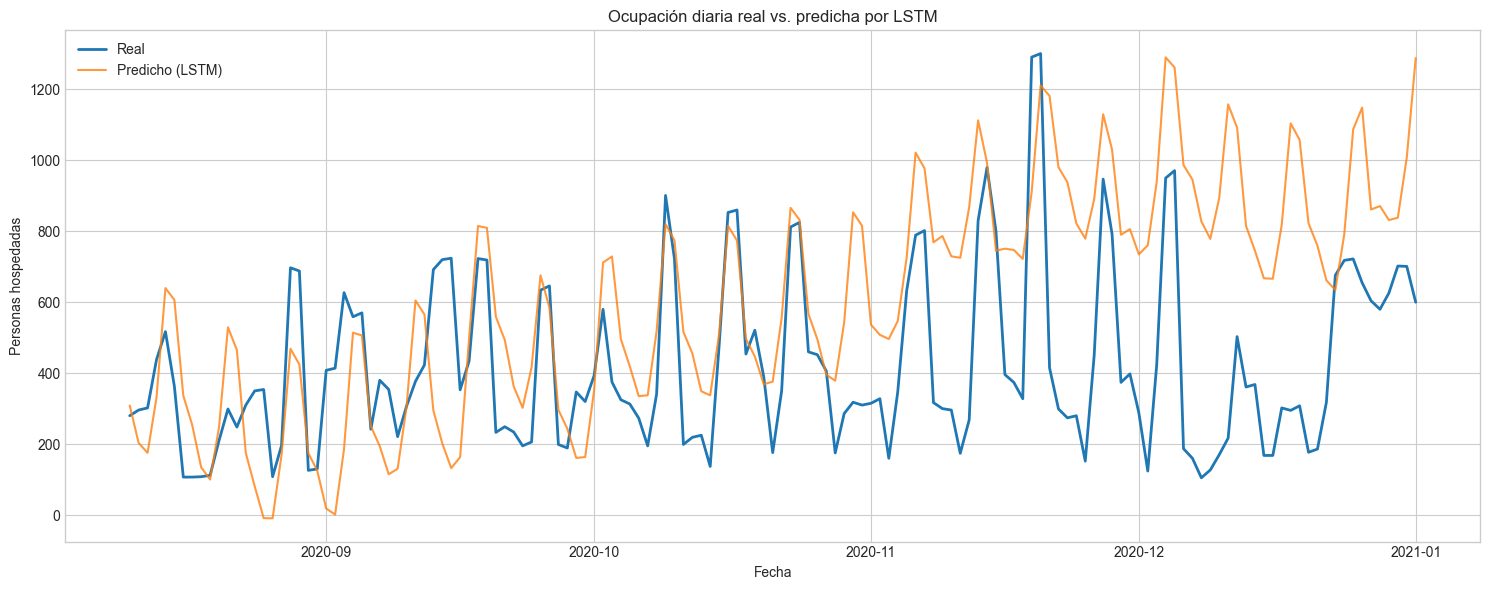

In [215]:
# 2. Graficar resultados
plt.figure(figsize=(15, 6))
plt.plot(df_seq.loc[test_idx, 'fecha'], y_test_real, label='Real', linewidth=2)
plt.plot(df_seq.loc[test_idx, 'fecha'], y_pred_real, label='Predicho (LSTM)', alpha=0.8)
plt.title('Ocupación diaria real vs. predicha por LSTM')
plt.xlabel('Fecha')
plt.ylabel('Personas hospedadas')
plt.legend()
plt.tight_layout()
plt.show()

In [216]:
# 3. Métricas finales
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 276.85
RMSE: 354.17


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

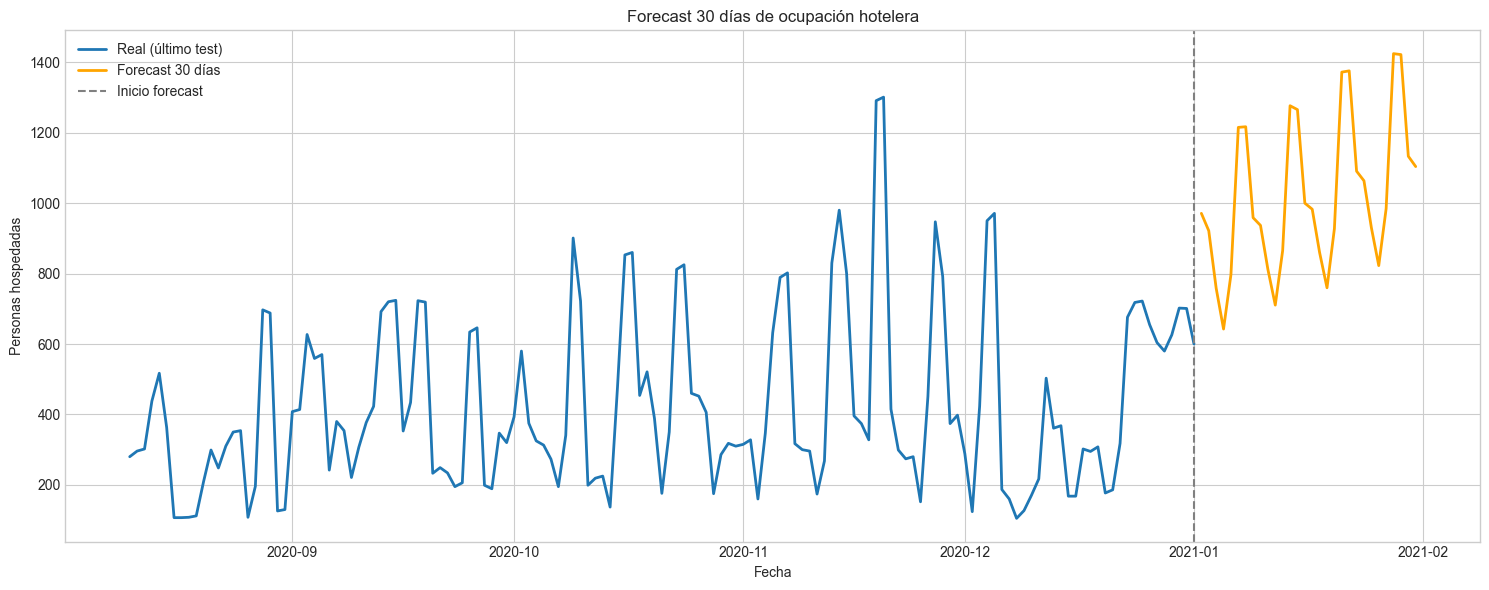

In [217]:
import copy

# Comenzamos con la última ventana real de features del set de test
last_window = df_seq.loc[test_idx, feature_cols].values[-N_HISTORY:].copy()
last_date = df_seq.loc[test_idx, 'fecha'].values[-1]

# Guardamos las fechas reales para las variables de calendario
forecast_dates = pd.date_range(last_date + np.timedelta64(1, 'D'), periods=30)

# Lista para guardar predicciones y features generados
forecast_preds = []
window = copy.deepcopy(last_window)  # Copia para modificar sin afectar lo anterior

for i, fecha in enumerate(forecast_dates):
    # Preparar features de calendario para la fecha de predicción
    dow = fecha.dayofweek
    month = fecha.month
    week = fecha.isocalendar()[1]
    quarter = (fecha.month - 1) // 3 + 1
    dow_sin = np.sin(2 * np.pi * dow / 7)
    dow_cos = np.cos(2 * np.pi * dow / 7)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    # es_viernes = int(dow == 4)
    # es_sabado = int(dow == 5)
    es_viernes_o_sabado = int(dow in [4, 5])
    temporada_alta = int(month in [6, 7, 11])
    es_festivo = int(fecha in holidays.MX(years=[2019, 2020]))
    es_pandemia = int(fecha >= pd.to_datetime('2020-03-01'))
    
    # Armar el input para el modelo
    # Rolling mean de 7 días, lags 1, 7, 14
    lag_1 = window[-1, feature_cols.index('lag_1')]  # Última predicción
    lag_7 = window[-7, feature_cols.index('lag_1')] if len(window) >= 7 else lag_1
    lag_14 = window[-14, feature_cols.index('lag_1')] if len(window) >= 14 else lag_1
    rolling_mean_7 = np.mean(window[-7:, feature_cols.index('lag_1')])
    
    # Nuevo input de features
    new_features = [
        lag_1, lag_7, lag_14, rolling_mean_7,
        dow_sin, dow_cos, 
        month_sin, month_cos,
        # es_viernes, es_sabado,
        temporada_alta, es_festivo,
        es_viernes_o_sabado, es_pandemia
    ]
    
    # Construir ventana input para LSTM
    window_for_model = np.vstack([window, new_features])[-N_HISTORY:]
    model_input = window_for_model.reshape((1, N_HISTORY, len(feature_cols)))
    
    # Predecir
    pred_norm = model.predict(model_input)[0, 0]
    forecast_preds.append(pred_norm)
    
    # Actualiza ventana: mueve todo y agrega el nuevo input con la predicción en lag_1
    next_row = new_features.copy()
    next_row[0] = pred_norm  # lag_1 ahora es la predicción
    window = np.vstack([window, next_row])[1:]  # Desplaza ventana

# Inversa la normalización de las predicciones
X_tmp_forecast = np.zeros((len(forecast_preds), len(features_to_scale)))
col_idx = features_to_scale.index('personas')
X_tmp_forecast[:, col_idx] = forecast_preds
forecast_preds_real = scaler.inverse_transform(X_tmp_forecast)[:, col_idx]

# Graficar forecast
plt.figure(figsize=(15, 6))
plt.plot(df_seq.loc[test_idx, 'fecha'], y_test_real, label='Real (último test)', linewidth=2)
plt.plot(forecast_dates, forecast_preds_real, label='Forecast 30 días', color='orange', linewidth=2)
plt.axvline(df_seq.loc[test_idx, 'fecha'].values[-1], color='grey', linestyle='--', label='Inicio forecast')
plt.title('Forecast 30 días de ocupación hotelera')
plt.xlabel('Fecha')
plt.ylabel('Personas hospedadas')
plt.legend()
plt.tight_layout()
plt.show()


## Random Forest

In [218]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Usa los mismos features (lags, rolling, calendario)
X = df_seq[feature_cols].values
y = df_seq['personas'].values  # ¡En escala real!

# Split como antes (usa los mismos índices de train/test)
X_train_rf, X_test_rf = X[train_idx.values], X[test_idx.values]
y_train_rf, y_test_rf = y[train_idx.values], y[test_idx.values]

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test_rf)



Random Forest MAE (real): 167.84
Random Forest RMSE (real): 214.75


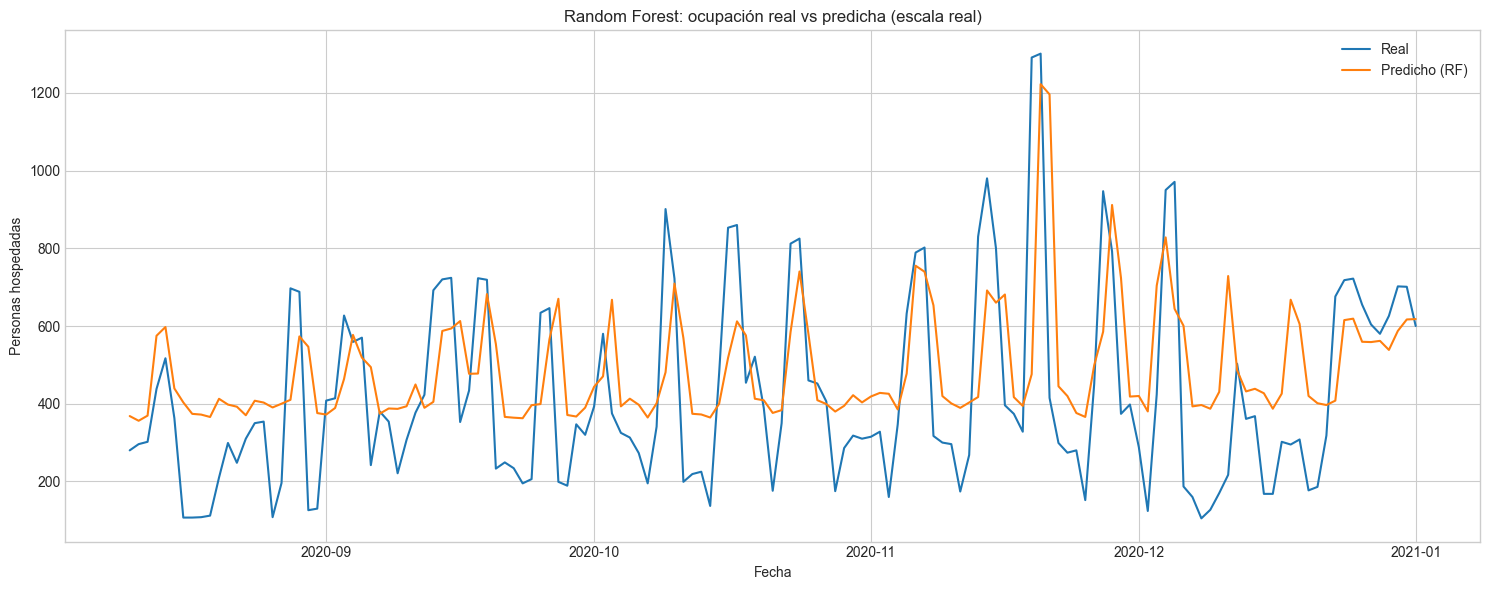

In [219]:
# Crear arrays dummy para inverse_transform
X_tmp_rf_pred = np.zeros((len(y_pred_rf), len(features_to_scale)))
col_idx = features_to_scale.index('personas')
X_tmp_rf_pred[:, col_idx] = y_pred_rf
y_pred_rf_real = scaler.inverse_transform(X_tmp_rf_pred)[:, col_idx]

X_tmp_rf_real = np.zeros((len(y_test_rf), len(features_to_scale)))
X_tmp_rf_real[:, col_idx] = y_test_rf
y_test_rf_real = scaler.inverse_transform(X_tmp_rf_real)[:, col_idx]


mae_rf_real = mean_absolute_error(y_test_rf_real, y_pred_rf_real)
rmse_rf_real = mean_squared_error(y_test_rf_real, y_pred_rf_real, squared=False)
print(f"Random Forest MAE (real): {mae_rf_real:.2f}")
print(f"Random Forest RMSE (real): {rmse_rf_real:.2f}")

# Gráfica en escala real
plt.figure(figsize=(15,6))
plt.plot(df_seq.loc[test_idx, 'fecha'], y_test_rf_real, label='Real')
plt.plot(df_seq.loc[test_idx, 'fecha'], y_pred_rf_real, label='Predicho (RF)')
plt.title('Random Forest: ocupación real vs predicha (escala real)')
plt.xlabel('Fecha')
plt.ylabel('Personas hospedadas')
plt.legend()
plt.tight_layout()
plt.show()


## XGBOOST

XGBoost MAE (real): 218.29
XGBoost RMSE (real): 266.35


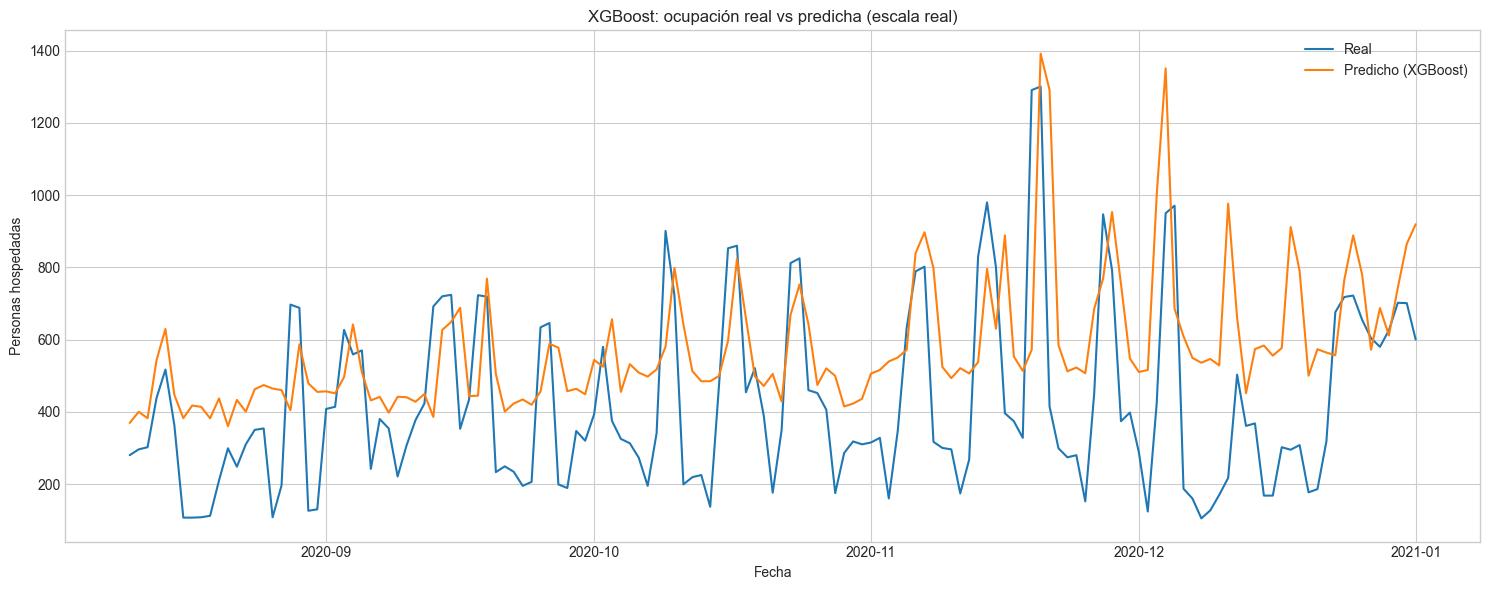

In [220]:
from xgboost import XGBRegressor

# Entrenamiento
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_rf, y_train_rf)

# Predicción
y_pred_xgb = xgb.predict(X_test_rf)

# Inverse scaling
X_tmp_xgb_pred = np.zeros((len(y_pred_xgb), len(features_to_scale)))
X_tmp_xgb_pred[:, col_idx] = y_pred_xgb
y_pred_xgb_real = scaler.inverse_transform(X_tmp_xgb_pred)[:, col_idx]

# Métricas
mae_xgb = mean_absolute_error(y_test_rf_real, y_pred_xgb_real)
rmse_xgb = mean_squared_error(y_test_rf_real, y_pred_xgb_real, squared=False)
print(f"XGBoost MAE (real): {mae_xgb:.2f}")
print(f"XGBoost RMSE (real): {rmse_xgb:.2f}")

# Gráfica
plt.figure(figsize=(15,6))
plt.plot(df_seq.loc[test_idx, 'fecha'], y_test_rf_real, label='Real')
plt.plot(df_seq.loc[test_idx, 'fecha'], y_pred_xgb_real, label='Predicho (XGBoost)')
plt.title('XGBoost: ocupación real vs predicha (escala real)')
plt.xlabel('Fecha')
plt.ylabel('Personas hospedadas')
plt.legend()
plt.tight_layout()
plt.show()


## LGBM

LightGBM MAE (real): 183.24
LightGBM RMSE (real): 232.85


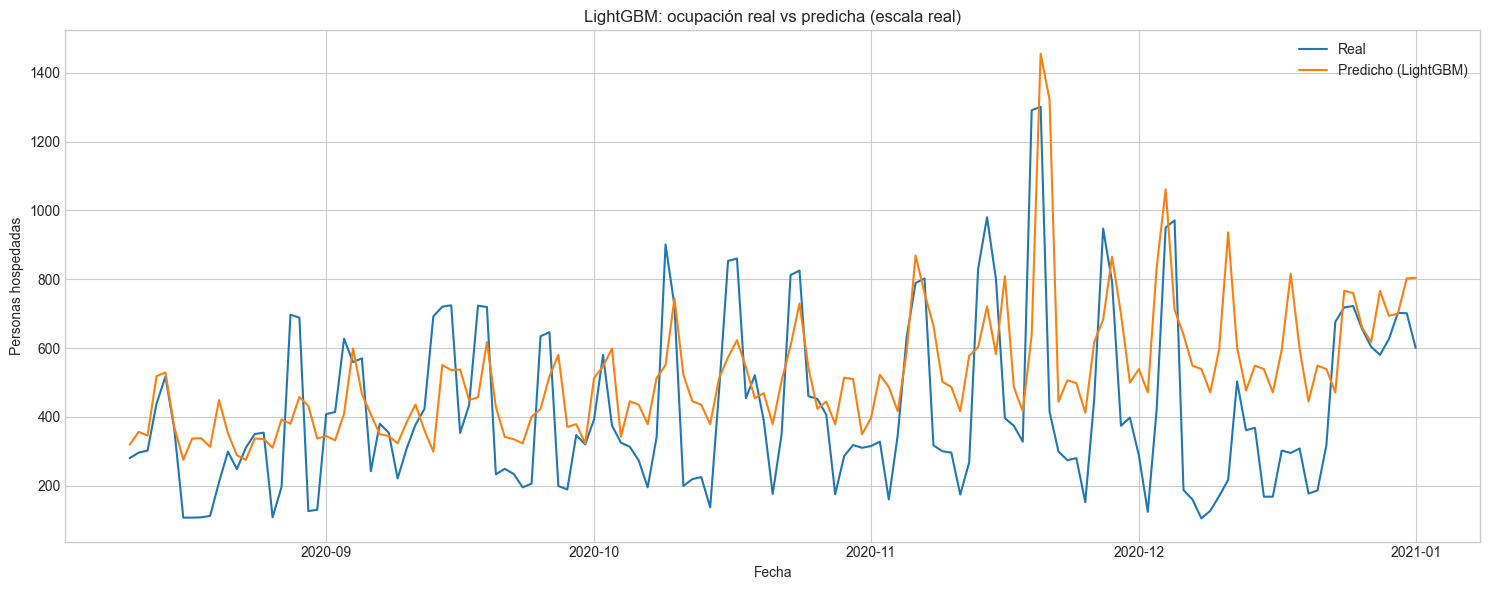

In [221]:
from lightgbm import LGBMRegressor

# Entrenamiento
lgb = LGBMRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
lgb.fit(X_train_rf, y_train_rf)

# Predicción
y_pred_lgb = lgb.predict(X_test_rf)

# Inverse scaling
X_tmp_lgb_pred = np.zeros((len(y_pred_lgb), len(features_to_scale)))
X_tmp_lgb_pred[:, col_idx] = y_pred_lgb
y_pred_lgb_real = scaler.inverse_transform(X_tmp_lgb_pred)[:, col_idx]

# Métricas
mae_lgb = mean_absolute_error(y_test_rf_real, y_pred_lgb_real)
rmse_lgb = mean_squared_error(y_test_rf_real, y_pred_lgb_real, squared=False)
print(f"LightGBM MAE (real): {mae_lgb:.2f}")
print(f"LightGBM RMSE (real): {rmse_lgb:.2f}")

# Gráfica
plt.figure(figsize=(15,6))
plt.plot(df_seq.loc[test_idx, 'fecha'], y_test_rf_real, label='Real')
plt.plot(df_seq.loc[test_idx, 'fecha'], y_pred_lgb_real, label='Predicho (LightGBM)')
plt.title('LightGBM: ocupación real vs predicha (escala real)')
plt.xlabel('Fecha')
plt.ylabel('Personas hospedadas')
plt.legend()
plt.tight_layout()
plt.show()


## Optuna

In [222]:
import optuna
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train_rf, y_train_rf)
    y_pred = model.predict(X_test_rf)
    # Inverse scaling
    X_tmp = np.zeros((len(y_pred), len(features_to_scale)))
    X_tmp[:, col_idx] = y_pred
    y_pred_real = scaler.inverse_transform(X_tmp)[:, col_idx]
    return mean_absolute_error(y_test_rf_real, y_pred_real)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=500)

print("Mejores hiperparámetros Random Forest:", study_rf.best_params)
print("Mejor MAE (real):", study_rf.best_value)



[I 2025-06-03 00:11:37,089] A new study created in memory with name: no-name-3aaacbb6-02b9-4d99-a73b-da92c6b9054e
[I 2025-06-03 00:11:37,497] Trial 0 finished with value: 229.95313767112108 and parameters: {'n_estimators': 358, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 229.95313767112108.
[I 2025-06-03 00:11:37,915] Trial 1 finished with value: 243.80082067243302 and parameters: {'n_estimators': 413, 'max_depth': 12, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 229.95313767112108.
[I 2025-06-03 00:11:38,300] Trial 2 finished with value: 167.49396782298146 and parameters: {'n_estimators': 335, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 2 with value: 167.49396782298146.
[I 2025-06-03 00:11:38,433] Trial 3 finished with value: 234.01561124351153 and parameters: {'n_estimators': 124, 'max_depth': 11, 'm

Mejores hiperparámetros Random Forest: {'n_estimators': 257, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}
Mejor MAE (real): 163.69947485175146


In [223]:
# Entrena el modelo óptimo encontrado por Optuna
best_params_rf = study_rf.best_params
best_params_rf['random_state'] = 42
best_params_rf['n_jobs'] = -1

rf_best = RandomForestRegressor(**best_params_rf)
rf_best.fit(X_train_rf, y_train_rf)

# Predice en test
y_pred_rf = rf_best.predict(X_test_rf)

# Inversa la normalización
X_tmp_rf_pred = np.zeros((len(y_pred_rf), len(features_to_scale)))
X_tmp_rf_pred[:, col_idx] = y_pred_rf
y_pred_rf_real = scaler.inverse_transform(X_tmp_rf_pred)[:, col_idx]

X_tmp_rf_real = np.zeros((len(y_test_rf), len(features_to_scale)))
X_tmp_rf_real[:, col_idx] = y_test_rf
y_test_rf_real = scaler.inverse_transform(X_tmp_rf_real)[:, col_idx]

# Métricas
mae_rf = mean_absolute_error(y_test_rf_real, y_pred_rf_real)
rmse_rf = mean_squared_error(y_test_rf_real, y_pred_rf_real, squared=False)
print(f"Random Forest MAE (real): {mae_rf:.2f}")
print(f"Random Forest RMSE (real): {rmse_rf:.2f}")


Random Forest MAE (real): 163.70
Random Forest RMSE (real): 209.04


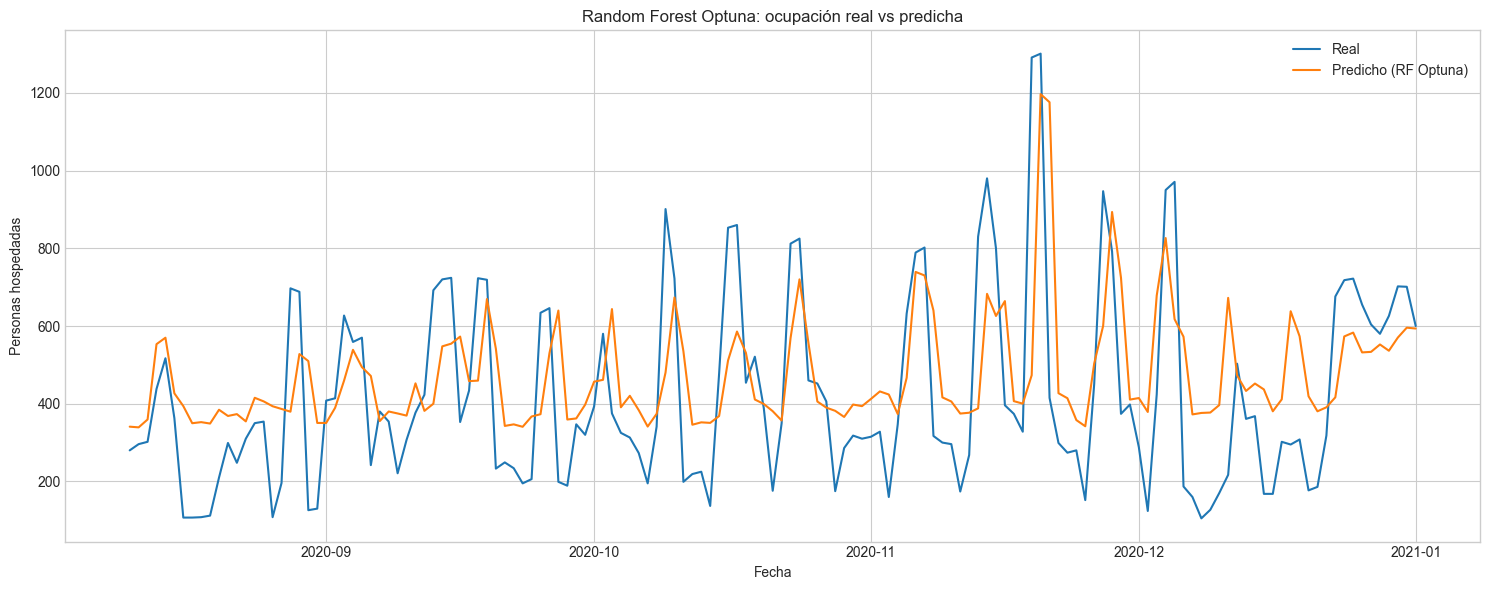

In [224]:
plt.figure(figsize=(15,6))
plt.plot(df_seq.loc[test_idx, 'fecha'], y_test_rf_real, label='Real')
plt.plot(df_seq.loc[test_idx, 'fecha'], y_pred_rf_real, label='Predicho (RF Optuna)')
plt.title('Random Forest Optuna: ocupación real vs predicha')
plt.xlabel('Fecha')
plt.ylabel('Personas hospedadas')
plt.legend()
plt.tight_layout()
plt.show()


In [225]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,  # Para suprimir mensajes de XGBoost
        'verbose': 0
    }
    model = XGBRegressor(**params)
    model.fit(X_train_rf, y_train_rf)
    y_pred = model.predict(X_test_rf)
    # Inverse scaling
    X_tmp = np.zeros((len(y_pred), len(features_to_scale)))
    X_tmp[:, col_idx] = y_pred
    y_pred_real = scaler.inverse_transform(X_tmp)[:, col_idx]
    return mean_absolute_error(y_test_rf_real, y_pred_real)

# Ejecutar el estudio
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=500)

print("Mejores hiperparámetros XGBoost:", study_xgb.best_params)
print("Mejor MAE (real):", study_xgb.best_value)


[I 2025-06-03 00:15:14,066] A new study created in memory with name: no-name-96dcb0a4-c0ea-4980-b7b8-6b1f8221b0a3
[I 2025-06-03 00:15:14,294] Trial 0 finished with value: 196.36858708514222 and parameters: {'n_estimators': 456, 'max_depth': 9, 'learning_rate': 0.12802040496715195, 'subsample': 0.8649376734310575, 'colsample_bytree': 0.7346845523540321}. Best is trial 0 with value: 196.36858708514222.
[I 2025-06-03 00:15:14,359] Trial 1 finished with value: 194.22932235652516 and parameters: {'n_estimators': 223, 'max_depth': 4, 'learning_rate': 0.08426239887177549, 'subsample': 0.7108853614928705, 'colsample_bytree': 0.8515936025179276}. Best is trial 1 with value: 194.22932235652516.
[I 2025-06-03 00:15:14,466] Trial 2 finished with value: 203.26242297168434 and parameters: {'n_estimators': 330, 'max_depth': 5, 'learning_rate': 0.20421994080132302, 'subsample': 0.750933862566563, 'colsample_bytree': 0.7663141673675702}. Best is trial 1 with value: 194.22932235652516.
[I 2025-06-03 00:

Mejores hiperparámetros XGBoost: {'n_estimators': 270, 'max_depth': 4, 'learning_rate': 0.0495335621929672, 'subsample': 0.9611177903071413, 'colsample_bytree': 0.7157258215274596}
Mejor MAE (real): 148.33540086386532


In [226]:
# Entrenar LGBM con los mejores hiperparámetros de Optuna
best_params_xgb = study_xgb.best_params
best_params_xgb['random_state'] = 42
best_params_xgb['n_jobs'] = -1

xgb_best = XGBRegressor(**best_params_xgb)
xgb_best.fit(X_train_rf, y_train_rf)

# Predice sobre el set de test
y_pred_xgb = xgb_best.predict(X_test_rf)


In [227]:
# Desnormalizar
X_tmp_xgb_pred = np.zeros((len(y_pred_xgb), len(features_to_scale)))
X_tmp_xgb_pred[:, col_idx] = y_pred_xgb
y_pred_xgb_real = scaler.inverse_transform(X_tmp_xgb_pred)[:, col_idx]

X_tmp_xgb_real = np.zeros((len(y_test_rf), len(features_to_scale)))
X_tmp_xgb_real[:, col_idx] = y_test_rf
y_test_rf_real = scaler.inverse_transform(X_tmp_xgb_real)[:, col_idx]

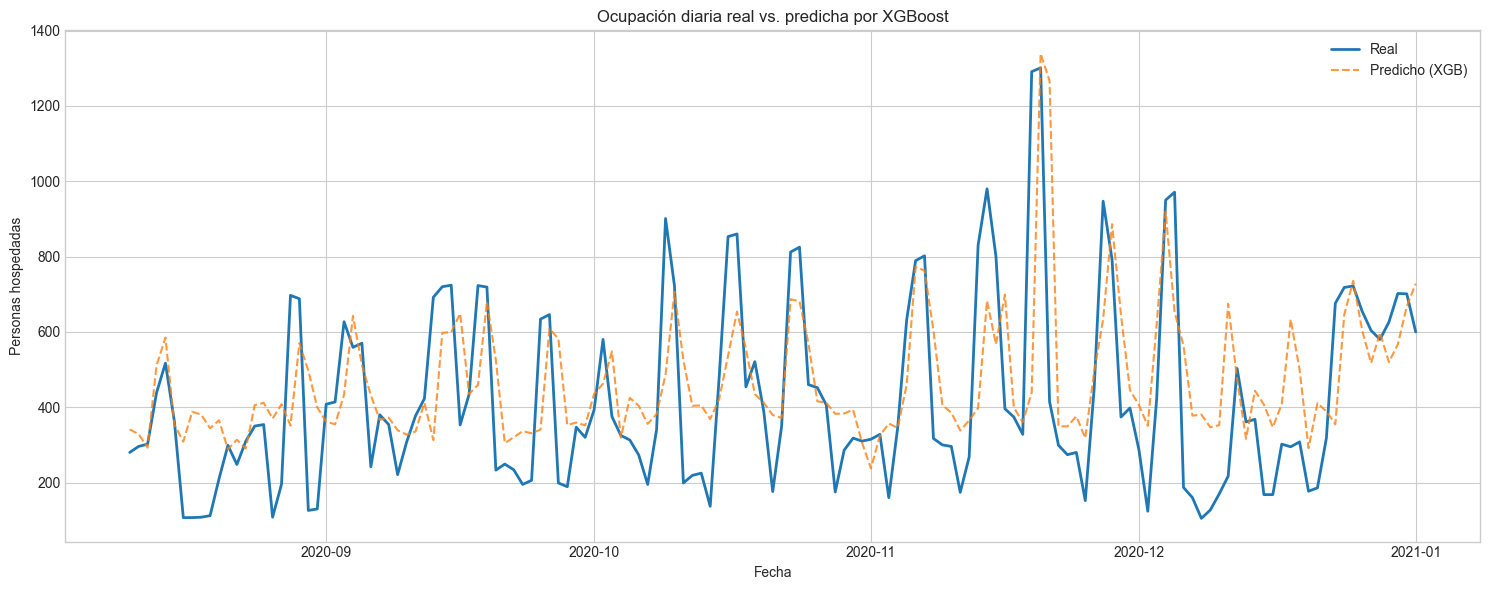

XGBoost MAE (real): 148.34
XGBoost RMSE (real): 203.05


In [228]:
import matplotlib.pyplot as plt

# Crear un dataframe para comparación
comparacion = pd.DataFrame({
    'fecha': df_seq.loc[test_idx, 'fecha'].values,
    'real': y_test_rf_real,
    'predicho': y_pred_xgb_real
})


# Gráfica comparativa de predicho vs real
plt.figure(figsize=(15,6))
plt.plot(comparacion['fecha'], comparacion['real'], label='Real', linewidth=2)
plt.plot(comparacion['fecha'], comparacion['predicho'], label='Predicho (XGB)', linestyle='--', alpha=0.8)
plt.title('Ocupación diaria real vs. predicha por XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Personas hospedadas')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Imprime el MAE y RMSE
mae_xgb = mean_absolute_error(comparacion['real'], comparacion['predicho'])
rmse_xgb = mean_squared_error(comparacion['real'], comparacion['predicho'], squared=False)
print(f"XGBoost MAE (real): {mae_xgb:.2f}")
print(f"XGBoost RMSE (real): {rmse_xgb:.2f}")

In [229]:
from lightgbm import LGBMRegressor

def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1,
        'verbose': -1
    }
    model = LGBMRegressor(**params)
    model.fit(X_train_rf, y_train_rf)
    y_pred = model.predict(X_test_rf)
    # Inverse scaling
    X_tmp = np.zeros((len(y_pred), len(features_to_scale)))
    X_tmp[:, col_idx] = y_pred
    y_pred_real = scaler.inverse_transform(X_tmp)[:, col_idx]
    return mean_absolute_error(y_test_rf_real, y_pred_real)

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=1000)

print("Mejores hiperparámetros LightGBM:", study_lgb.best_params)
print("Mejor MAE (real):", study_lgb.best_value)


[I 2025-06-03 00:16:08,779] A new study created in memory with name: no-name-31c27799-e0b1-46fa-afc2-3414766dda4e
[I 2025-06-03 00:16:08,961] Trial 0 finished with value: 174.4442052370666 and parameters: {'n_estimators': 443, 'max_depth': 10, 'learning_rate': 0.032338993556019775, 'subsample': 0.8263755109075223, 'colsample_bytree': 0.8687310911643124}. Best is trial 0 with value: 174.4442052370666.
[I 2025-06-03 00:16:09,082] Trial 1 finished with value: 154.06179942055456 and parameters: {'n_estimators': 101, 'max_depth': 8, 'learning_rate': 0.07902188659894484, 'subsample': 0.8473183361897354, 'colsample_bytree': 0.8258176327450757}. Best is trial 1 with value: 154.06179942055456.
[I 2025-06-03 00:16:09,121] Trial 2 finished with value: 152.7448355306099 and parameters: {'n_estimators': 146, 'max_depth': 3, 'learning_rate': 0.06420948215488037, 'subsample': 0.9098021198593309, 'colsample_bytree': 0.788914524808964}. Best is trial 2 with value: 152.7448355306099.
[I 2025-06-03 00:16

Mejores hiperparámetros LightGBM: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.07171618035303128, 'subsample': 0.9557597588976188, 'colsample_bytree': 0.7044136003653991}
Mejor MAE (real): 143.4739712594251


In [230]:
# Entrenar LGBM con los mejores hiperparámetros de Optuna
best_params_lgb = study_lgb.best_params
best_params_lgb['random_state'] = 42
best_params_lgb['n_jobs'] = -1

lgb_best = LGBMRegressor(**best_params_lgb)
lgb_best.fit(X_train_rf, y_train_rf)

# Predice sobre el set de test
y_pred_lgb = lgb_best.predict(X_test_rf)


In [231]:
# Desnormalizar
X_tmp_lgb_pred = np.zeros((len(y_pred_lgb), len(features_to_scale)))
X_tmp_lgb_pred[:, col_idx] = y_pred_lgb
y_pred_lgb_real = scaler.inverse_transform(X_tmp_lgb_pred)[:, col_idx]

X_tmp_lgb_real = np.zeros((len(y_test_rf), len(features_to_scale)))
X_tmp_lgb_real[:, col_idx] = y_test_rf
y_test_rf_real = scaler.inverse_transform(X_tmp_lgb_real)[:, col_idx]


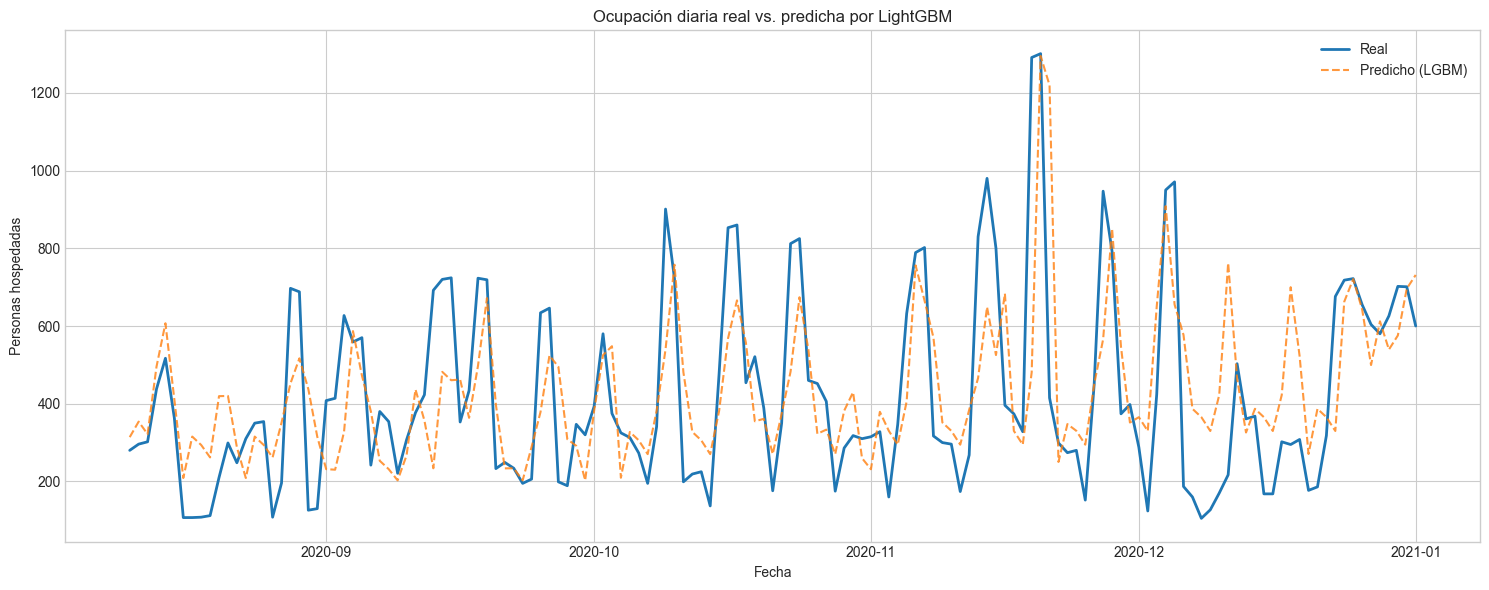

LightGBM MAE (real): 143.47
LightGBM RMSE (real): 195.25


In [232]:
import matplotlib.pyplot as plt

# Crear un dataframe para comparación
comparacion = pd.DataFrame({
    'fecha': df_seq.loc[test_idx, 'fecha'].values,
    'real': y_test_rf_real,
    'predicho': y_pred_lgb_real
})


# Gráfica comparativa de predicho vs real
plt.figure(figsize=(15,6))
plt.plot(comparacion['fecha'], comparacion['real'], label='Real', linewidth=2)
plt.plot(comparacion['fecha'], comparacion['predicho'], label='Predicho (LGBM)', linestyle='--', alpha=0.8)
plt.title('Ocupación diaria real vs. predicha por LightGBM')
plt.xlabel('Fecha')
plt.ylabel('Personas hospedadas')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Imprime el MAE y RMSE
mae_lgb = mean_absolute_error(comparacion['real'], comparacion['predicho'])
rmse_lgb = mean_squared_error(comparacion['real'], comparacion['predicho'], squared=False)
print(f"LightGBM MAE (real): {mae_lgb:.2f}")
print(f"LightGBM RMSE (real): {rmse_lgb:.2f}")



In [233]:
resultados = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost', 'LightGBM'],
    'MAE': [mae_rf, mae_xgb, mae_lgb],
    'RMSE': [rmse_rf, rmse_xgb, rmse_lgb]
})

# Redondear para mejor presentación
resultados = resultados.round(2)

print(resultados)

          Modelo     MAE    RMSE
0  Random Forest  163.70  209.04
1        XGBoost  148.34  203.05
2       LightGBM  143.47  195.25


## Forecasting de 30 dias

In [ ]:
def forecast_tabular(model, last_window, last_date, feature_cols, N_HISTORY=14, days=30):
    import copy
    forecast_preds = []
    forecast_dates = pd.date_range(last_date + np.timedelta64(1, 'D'), periods=days)
    window = copy.deepcopy(last_window)
    for i, fecha in enumerate(forecast_dates):
        # Features de calendario
        dow = fecha.dayofweek
        month = fecha.month
        week = fecha.isocalendar()[1]
        quarter = (fecha.month - 1) // 3 + 1
        dow_sin = np.sin(2 * np.pi * dow / 7)
        dow_cos = np.cos(2 * np.pi * dow / 7)
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)
        # es_viernes = int(dow == 4)
        # es_sabado = int(dow == 5)
        es_viernes_o_sabado = int(dow in [4, 5])
        temporada_alta = int(month in [6, 7, 11])
        es_festivo = int(fecha in holidays.MX(years=[2019, 2020, 2021]))
        es_pandemia = int(fecha >= pd.to_datetime('2020-03-01'))
        
        # Rolling y lags con predicciones previas
        lag_1 = window[-1, feature_cols.index('lag_1')]
        lag_7 = window[-7, feature_cols.index('lag_1')] if len(window) >= 7 else lag_1
        lag_14 = window[-14, feature_cols.index('lag_1')] if len(window) >= 14 else lag_1
        rolling_mean_7 = np.mean(window[-7:, feature_cols.index('lag_1')])
        
        
        new_features = [
            lag_1, lag_7, lag_14, rolling_mean_7,
            dow_sin, dow_cos, 
            month_sin, month_cos,
            # es_viernes, es_sabado,
            temporada_alta, es_festivo,
            es_viernes_o_sabado, es_pandemia
        ]
        
        # Modelo espera un array 2D de features para cada día
        pred = model.predict(np.array(new_features).reshape(1, -1))[0]
        forecast_preds.append(pred)
        
        # Actualiza ventana para siguientes lags/rollings
        next_row = new_features.copy()
        next_row[0] = pred  # lag_1 = predicción actual
        window = np.vstack([window, next_row])[1:]
    return forecast_dates, np.array(forecast_preds)


In [248]:
# Última ventana de test (normalizada, igual que para LSTM)
last_window_rf = df_seq.loc[test_idx, feature_cols].values[-N_HISTORY:].copy()
last_date_rf = df_seq.loc[test_idx, 'fecha'].values[-1]

# Random Forest
forecast_dates_rf, forecast_preds_rf = forecast_tabular(rf_best, last_window_rf, last_date_rf, feature_cols, N_HISTORY=N_HISTORY, days=30)
# LightGBM
forecast_dates_lgb, forecast_preds_lgb = forecast_tabular(lgb_best, last_window_rf, last_date_rf, feature_cols, N_HISTORY=N_HISTORY, days=30)
# XGBoost
forecast_dates_xgb, forecast_preds_xgb = forecast_tabular(xgb_best, last_window_rf, last_date_rf, feature_cols, N_HISTORY=N_HISTORY, days=30)

# Inverse scaling
X_tmp_rf_forecast = np.zeros((len(forecast_preds_rf), len(features_to_scale)))
X_tmp_rf_forecast[:, col_idx] = forecast_preds_rf
forecast_rf_real = scaler.inverse_transform(X_tmp_rf_forecast)[:, col_idx]

X_tmp_lgb_forecast = np.zeros((len(forecast_preds_lgb), len(features_to_scale)))
X_tmp_lgb_forecast[:, col_idx] = forecast_preds_lgb
forecast_lgb_real = scaler.inverse_transform(X_tmp_lgb_forecast)[:, col_idx]

X_tmp_xgb_forecast = np.zeros((len(forecast_preds_xgb), len(features_to_scale)))
X_tmp_xgb_forecast[:, col_idx] = forecast_preds_xgb
forecast_xgb_real = scaler.inverse_transform(X_tmp_xgb_forecast)[:, col_idx]


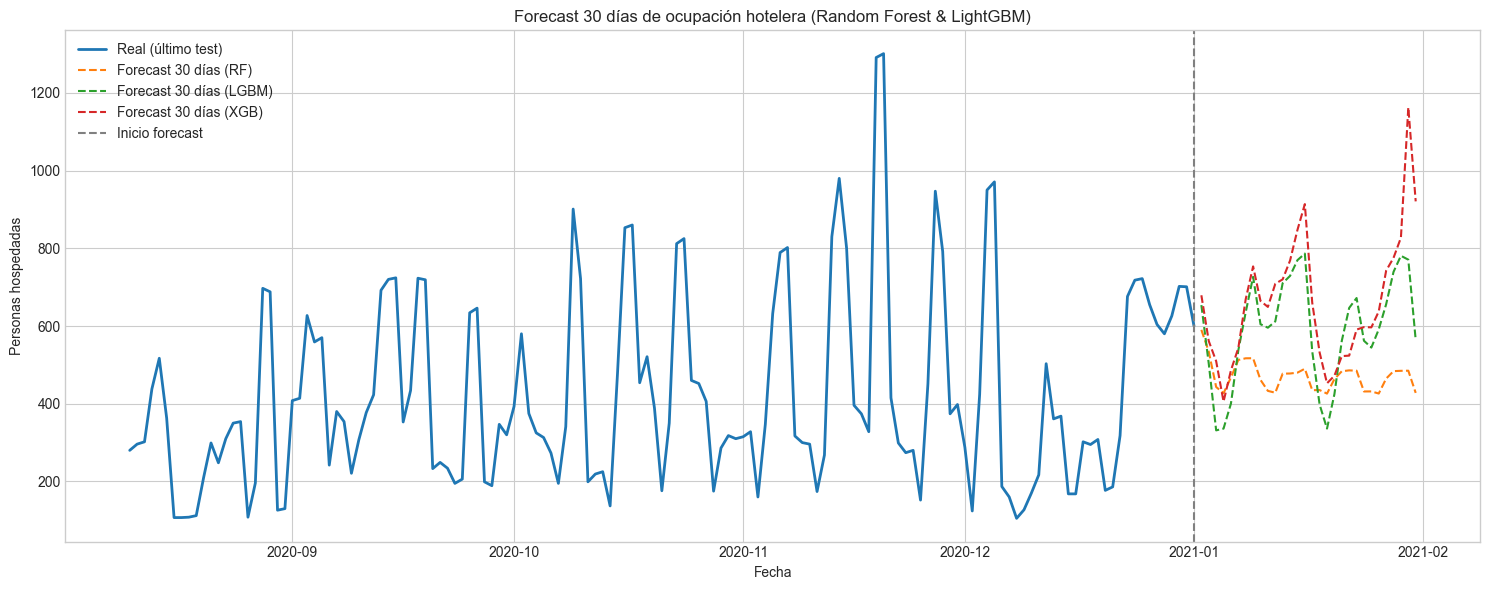

In [249]:
plt.figure(figsize=(15,6))
plt.plot(df_seq.loc[test_idx, 'fecha'], y_test_rf_real, label='Real (último test)', linewidth=2)
plt.plot(forecast_dates_rf, forecast_rf_real, label='Forecast 30 días (RF)', linestyle='--')
plt.plot(forecast_dates_lgb, forecast_lgb_real, label='Forecast 30 días (LGBM)', linestyle='--')
plt.plot(forecast_dates_xgb, forecast_xgb_real, label='Forecast 30 días (XGB)', linestyle='--')
plt.axvline(df_seq.loc[test_idx, 'fecha'].values[-1], color='grey', linestyle='--', label='Inicio forecast')
plt.title('Forecast 30 días de ocupación hotelera (Random Forest & LightGBM)')
plt.xlabel('Fecha')
plt.ylabel('Personas hospedadas')
plt.legend()
plt.tight_layout()
plt.show()
